In [1]:
%load_ext autoreload
%matplotlib inline

%autoreload 2

# %load_ext watermark
# %watermark -v -n -m -p numpy,scipy,sklearn,pandas,tensorflow,keras



In [2]:
from data.preprocess import PreProcessor

data = PreProcessor(config=PreProcessor.DEFAULT_CONFIG,
                    data_dir='data/raw/r252-corpus-features/org/elasticsearch/action/admin/')
# data = PreProcessor(config=PreProcessor.DEFAULT_CONFIG,
#                     data_dir='data/raw/r252-corpus-features/org/elasticsearch/')

vocab = data.metadata['token_vocab']
processed = data.get_tensorise_data()


In [144]:
import numpy as np
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers

from models.cnn_attention import ConvAttention
from utils.activations import masked_sparse_cross_entropy_loss

vocabulary_size = len(vocab) + 1
max_chunk_length = data.config['max_chunk_length']
code_snippet = processed['body_tokens']
# code_snippet = np.expand_dims(processed['body_tokens'], -1)
# label_name = np.expand_dims(processed['name_tokens'], axis=-1)
label_name = processed['name_tokens']
# label_name = keras.utils.to_categorical(processed['name_tokens'], num_classes=vocabulary_size)
print("Vocab Size: {} number of Code snippet: {} number of labels: {}".format(vocabulary_size, len(code_snippet),
                                                                              len(label_name)))
print("Label_name shape: {}\nCode_snippet shape: {}".format(label_name.shape, code_snippet.shape))

# TODO make the input a json file and parse it
hyperparameter = {'batch_size': 1, 'k1': 8, 'k2': 8, 'w1': 24, 'w2': 29, 'w3': 10, 'dropout_rate': 0.5,
                  'max_chunk_length': max_chunk_length, 'vocabulary_size': vocabulary_size, 'embedding_dim': 128}
# Optimised hyperparameter are reported in page 5 of the paper

batch_size = hyperparameter['batch_size']
# define layers
main_input = layers.Input(shape=(max_chunk_length,),
                          batch_size=batch_size,
                          dtype=tf.int32, name='main_input',
                          )

cnn_layer = ConvAttention(hyperparameter)

optimizer = keras.optimizers.Nadam()  # RMSprop with Nesterov momentum
# loss_func = masked_sparse_cross_entropy_loss
loss_func = keras.losses.sparse_categorical_crossentropy

# define execution
cnn_output = cnn_layer(main_input)
model = keras.Model(inputs=[main_input], outputs=cnn_output)
model.compile(optimizer=optimizer,
              loss=loss_func,
              # metrics=['accuracy'],
              )
# fit the model
# tbCallBack = 
# keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
history = model.fit(code_snippet,
                    label_name,
                    epochs=5,
                    verbose=2,
                    batch_size=batch_size,
                    # callbacks=[tbCallBack],
                    validation_split=0.2)


Vocab Size: 907 number of Code snippet: 518 number of labels: 518
Label_name shape: (518, 100)
Code_snippet shape: (518, 100)
ConvAttention: Tokens shape = (1, 100, 128), h_t shape = (1, 8)
AttentionFeatures: C shape = (1, 100, 128), h_t shape = (1, 8)
AttentionFeatures: L_1 shape = (1, 100, 8)


AttentionFeatures: L_2 shape = (1, 100, 8)
AttentionFeatures: L_2 shape  after multiply = (1, 100, 8)
AttentionFeatures: L_feat shape = (1, 100, 8)
ConvAttention: L_feat shape = (1, 100, 8)
AttentionWeights: l_feat shape = (1, 100, 8)
AttentionWeights: attention_weight shape = (1, 100, 1)
ConvAttention: alpha shape = (1, 100)
ConvAttention: n_hat shape = (1, 128)
ConvAttention: n shape = (1, 907)


ValueError: Dimensions must be equal, but are 907 and 100 for 'conv_attention_56/MatMul_1' (op: 'MatMul') with input shapes: [1,907], [100,128].

In [140]:
np.squeeze(label_name, -1).shape

(518, 100)

In [99]:
cnn_layer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn_att_embedding (Embedding (2, 100, 128)             116096    
_________________________________________________________________
cnn_att_gru (GRU)            [(2, 8), (2, 8)]          3288      
_________________________________________________________________
attention_features_36 (Atten (2, 100, 8)               26448     
_________________________________________________________________
attention_weights_36 (Attent multiple                  81        
_________________________________________________________________
cnn_att_dense (Dense)        multiple                  91607     
Total params: 237,520
Trainable params: 237,520
Non-trainable params: 0
_________________________________________________________________


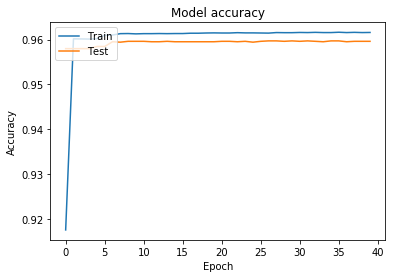

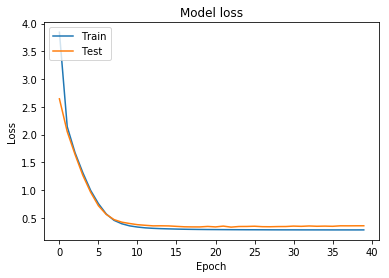

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [9]:
# # overfit and evaluate the model 
loss, accuracy = model.evaluate(code_snippet, label_name, batch_size=1, verbose=0)
print('Accuracy: {}'.format(accuracy * 100))


Accuracy: 96.1235523223877


In [6]:
# tf.keras.models.save_model(
#     model,
#     'test',
#     overwrite=True,
#     include_optimizer=True
# )
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")


Saved model to disk


In [60]:
# translate prediction

from data.utils import translate_tokenized_array_to_list_words, predict_name

model.reset_states()
prediction1 = model.predict(code_snippet[29].reshape(1, -1), steps=100)
print(prediction1.argmax(2))
# prediction2 = model.predict(np.squeeze(prediction1.argmax(2), 0), steps=1)
# translate_tokenized_array_to_list_words(vocab, label_name[9].reshape(1, -1)[0])
# translate_tokenized_array_to_list_words(vocab, [10])
# predict_name(vocab, model, code_snippet[21].reshape(1, -1))
# translate_tokenized_array_to_list_words(vocab, prediction.argmax(2)[0])
# print(prediction2.argmax(2))
# prediction.argmax(2)
# label_name.shape
# code_snippet.shape



[[10  0  0 ...  0  0  0]
 [10  0  0 ...  0  0  0]
 [10  0  0 ...  0  0  0]
 ...
 [10  0  0 ...  0  0  0]
 [10  0  0 ...  0  0  0]
 [10  0  0 ...  0  0  0]]


In [62]:
label_name[0][0]

array([10])